# Marginal Effects in Discrete Choice Models

**Tutorial Series**: Discrete Choice Econometrics with PanelBox

**Notebook**: 04 — Marginal Effects

**Date**: 2026-02-16

**Estimated Duration**: 75 minutes

**Difficulty Level**: Intermediate

**Prerequisite**: Notebook 01 (Binary Choice Introduction)

---

## Learning Objectives

By the end of this notebook, you will be able to:

1. Understand why coefficients (β) are **not** marginal effects in nonlinear models
2. Calculate **Marginal Effects at Means (MEM)**, **Average Marginal Effects (AME)**, and **Marginal Effects at Representative values (MER)**
3. Compute marginal effects for **continuous** and **dummy** variables correctly
4. Calculate **standard errors** using the delta method
5. Compute marginal effects for **Fixed Effects Logit** models
6. **Visualize** how marginal effects vary across observations
7. **Report** marginal effects appropriately in tables and text

---

## Table of Contents

1. [Setup](#section0)
2. [Why β ≠ Marginal Effect](#section1)
3. [Three Approaches to Marginal Effects](#section2)
4. [Computing AME Step-by-Step](#section3)
5. [Marginal Effects for Dummy Variables](#section4)
6. [Standard Errors via Delta Method](#section5)
7. [Marginal Effects in Fixed Effects Logit](#section6)
8. [Visualizing Marginal Effects](#section7)
9. [Application: Education and Labor Force Participation](#section8)
10. [Reporting Marginal Effects](#section9)
11. [Exercises](#exercises)

<a id='section0'></a>
## 0. Setup

Import all required libraries and configure the environment.

In [1]:
# Standard library
import warnings
from pathlib import Path

# Numerical computing and data manipulation
import numpy as np
import pandas as pd

# Statistical distributions
from scipy.stats import norm, logistic

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# PanelBox models
from panelbox.models.discrete.binary import PooledLogit, PooledProbit, FixedEffectsLogit

# PanelBox marginal effects
from panelbox.marginal_effects import compute_ame, compute_mem, compute_mer

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)

# Matplotlib configuration
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Data directory
DATA_DIR = Path('..') / 'data'
OUTPUT_DIR = Path('..') / 'outputs'
(OUTPUT_DIR / 'figures').mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / 'tables').mkdir(parents=True, exist_ok=True)

print('✓ All libraries imported successfully')
print(f'✓ Random seed set to: 42')
print(f'✓ Working directory: {Path.cwd()}')

✓ All libraries imported successfully
✓ Random seed set to: 42
✓ Working directory: /home/guhaase/projetos/panelbox/examples/discrete/notebooks


In [2]:
# Load the labor participation dataset
data = pd.read_csv(DATA_DIR / 'labor_participation.csv')

print('Dataset loaded successfully!')
print(f'\nShape: {data.shape}')
print(f'Individuals: {data["id"].nunique()}')
print(f'Periods: {data["year"].nunique()}')
print(f'\nColumns: {list(data.columns)}')
print(f'\nFirst 5 rows:')
data.head()

Dataset loaded successfully!

Shape: (5000, 8)
Individuals: 1000
Periods: 5

Columns: ['id', 'year', 'lfp', 'age', 'educ', 'kids', 'married', 'exper']

First 5 rows:


,id,year,lfp,age,educ,kids,married,exper
0,1,1,0,36,10,0,1,20
1,1,2,1,37,10,0,0,21
2,1,3,0,38,10,0,0,22
3,1,4,0,39,10,2,1,23
4,1,5,1,40,10,2,1,24


In [3]:
# Summary statistics
print('=== Summary Statistics ===')
data.describe()

=== Summary Statistics ===


,id,year,lfp,age,educ,kids,married,exper
count,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000
mean,500.5000,3.0000,0.6056,36.6100,13.4490,0.5944,0.5398,17.1850
std,288.7039,1.4144,0.4888,5.8618,2.3192,0.8803,0.4985,6.3758
min,1.0000,1.0000,0.0000,25.0000,10.0000,0.0000,0.0000,1.0000
25%,250.7500,2.0000,0.0000,32.0000,11.0000,0.0000,0.0000,12.0000
50%,500.5000,3.0000,1.0000,37.0000,13.0000,0.0000,1.0000,17.0000
75%,750.2500,4.0000,1.0000,42.0000,16.0000,1.0000,1.0000,22.0000
max,1000.0000,5.0000,1.0000,48.0000,17.0000,6.0000,1.0000,34.0000


<a id='section1'></a>
## 1. Why β ≠ Marginal Effect

### 1.1 The Core Problem

In **linear models**, the coefficient is directly the marginal effect:

$$E[y | \mathbf{X}] = \mathbf{X}'\boldsymbol{\beta} \implies \frac{\partial E[y|\mathbf{X}]}{\partial x_k} = \beta_k \quad \text{(constant!)}$$

In **Logit/Probit models**, the probability depends on $F(\mathbf{X}'\boldsymbol{\beta})$:

$$P(y=1|\mathbf{X}) = F(\mathbf{X}'\boldsymbol{\beta}) \implies \frac{\partial P}{\partial x_k} = f(\mathbf{X}'\boldsymbol{\beta}) \cdot \beta_k$$

where $f(\cdot) = F'(\cdot)$ is the probability density function. This **varies with X** — a different marginal effect at every observation!

| Model | $\partial P / \partial x_k$ | Varies with X? |
|-------|--------------------------|----------------|
| **OLS / LPM** | $\beta_k$ | No (constant) |
| **Logit** | $\Lambda(\mathbf{X}'\boldsymbol{\beta})[1-\Lambda(\mathbf{X}'\boldsymbol{\beta})] \cdot \beta_k$ | Yes |
| **Probit** | $\phi(\mathbf{X}'\boldsymbol{\beta}) \cdot \beta_k$ | Yes |

In [4]:
# Demonstrate that ME varies with X'beta
beta_educ = 0.5  # hypothetical education coefficient

print('=== Marginal Effect of Education in Logit ===')
print(f'Coefficient β = {beta_educ}\n')
print(f'{"X\'β":>8}  {"P(y=1)":>8}  {"f(X\'β)": >10}  {"ME":>8}  {"ME = β?":>10}')
print('-' * 58)

xbeta_values = np.array([-3, -2, -1, 0, 1, 2, 3])
me_values = []
for xb in xbeta_values:
    Lambda = 1 / (1 + np.exp(-xb))
    pdf    = Lambda * (1 - Lambda)      # logistic PDF
    me     = pdf * beta_educ
    me_values.append(me)
    print(f'{xb:>+8.1f}  {Lambda:>8.4f}  {pdf:>10.4f}  {me:>8.4f}  '
          f'{"NO (β=" + str(beta_educ) + ")": >10}')

print(f'\n→ The marginal effect ranges from {min(me_values):.4f} to {max(me_values):.4f}')
print(f'→ It is NEVER simply equal to β = {beta_educ}')

=== Marginal Effect of Education in Logit ===
Coefficient β = 0.5

     X'β    P(y=1)      f(X'β)        ME     ME = β?
----------------------------------------------------------
    -3.0    0.0474      0.0452    0.0226  NO (β=0.5)
    -2.0    0.1192      0.1050    0.0525  NO (β=0.5)
    -1.0    0.2689      0.1966    0.0983  NO (β=0.5)
    +0.0    0.5000      0.2500    0.1250  NO (β=0.5)
    +1.0    0.7311      0.1966    0.0983  NO (β=0.5)
    +2.0    0.8808      0.1050    0.0525  NO (β=0.5)
    +3.0    0.9526      0.0452    0.0226  NO (β=0.5)

→ The marginal effect ranges from 0.0226 to 0.1250
→ It is NEVER simply equal to β = 0.5


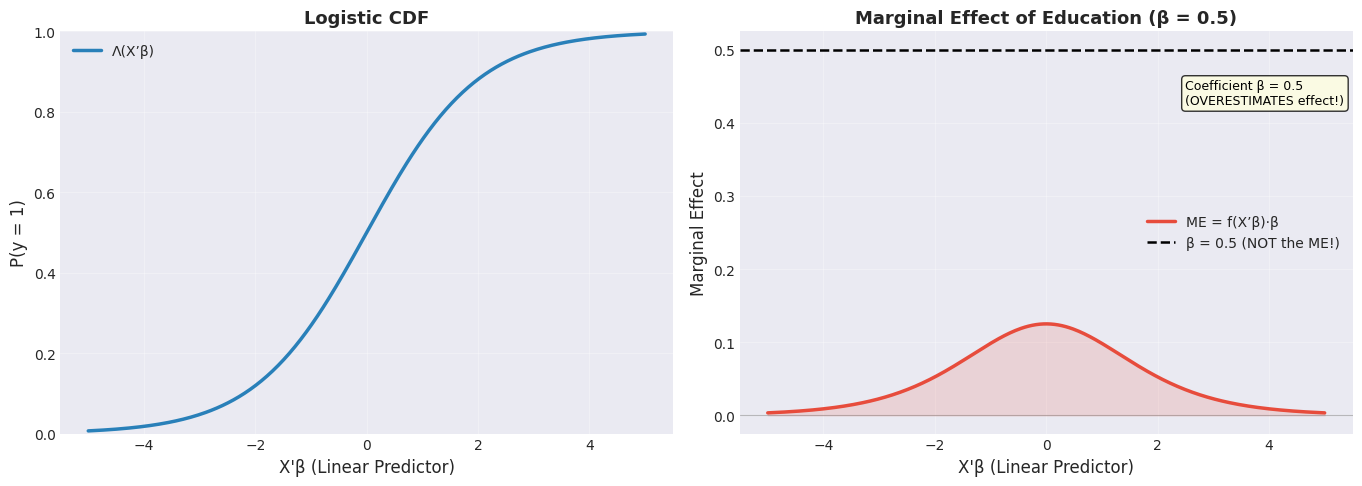


Key insight: The true marginal effect peaks at X’β = 0 (P = 0.5)
Maximum ME = 0.1250 at P = 0.5
Coefficient β = 0.5 (always overestimates ME except at the peak)


In [5]:
# Visualize the non-constancy of the marginal effect
x_grid = np.linspace(-5, 5, 300)
Lambda_grid = 1 / (1 + np.exp(-x_grid))
pdf_grid    = Lambda_grid * (1 - Lambda_grid)
me_grid     = pdf_grid * beta_educ

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Logistic CDF
axes[0].plot(x_grid, Lambda_grid, linewidth=2.5, color='#2980b9', label='Λ(X\u2019β)')
axes[0].set_xlabel("X'β (Linear Predictor)", fontsize=12)
axes[0].set_ylabel('P(y = 1)', fontsize=12)
axes[0].set_title('Logistic CDF', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_ylim([0, 1])

# Right: Marginal Effect vs X'beta
axes[1].plot(x_grid, me_grid, linewidth=2.5, color='#e74c3c', label='ME = f(X\u2019β)·β')
axes[1].axhline(y=beta_educ, color='black', linestyle='--', linewidth=1.8,
                label=f'β = {beta_educ} (NOT the ME!)')
axes[1].axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
axes[1].set_xlabel("X'β (Linear Predictor)", fontsize=12)
axes[1].set_ylabel('Marginal Effect', fontsize=12)
axes[1].set_title(f'Marginal Effect of Education (β = {beta_educ})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Shade the range
axes[1].fill_between(x_grid, 0, me_grid, alpha=0.15, color='#e74c3c')
axes[1].text(2.5, beta_educ * 0.85, f'Coefficient β = {beta_educ}\n(OVERESTIMATES effect!)',
             fontsize=9, color='black',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 's1_beta_vs_me.png', dpi=150, bbox_inches='tight')
plt.show()
print('\nKey insight: The true marginal effect peaks at X\u2019β = 0 (P = 0.5)')
print(f'Maximum ME = {pdf_grid.max() * beta_educ:.4f} at P = 0.5')
print(f'Coefficient β = {beta_educ} (always overestimates ME except at the peak)')

### 1.2 Implication for Empirical Work

**Rule**: Never report raw Logit/Probit coefficients as marginal effects. Always compute and report proper marginal effects.

> **The coefficient β tells you the direction and statistical significance of the effect.**  
> **The marginal effect tells you the economic magnitude.**

Since the marginal effect depends on the evaluation point (X), we need a convention. Three are widely used:

1. **MEM** — evaluate at the sample *mean* of X
2. **AME** — average across all observations (best practice)
3. **MER** — evaluate at researcher-chosen representative values

<a id='section2'></a>
## 2. Three Approaches to Marginal Effects

### 2.1 Approach Formulas

| Approach | Formula | Evaluation Point |
|----------|---------|------------------|
| **MEM** | $f(\bar{\mathbf{X}}'\boldsymbol{\beta}) \cdot \beta_k$ | Sample mean $\bar{\mathbf{X}}$ |
| **AME** ⭐ | $\frac{1}{N}\sum_i f(\mathbf{X}_i'\boldsymbol{\beta}) \cdot \beta_k$ | Every observation |
| **MER** | $f(\mathbf{X}^*{}'\boldsymbol{\beta}) \cdot \beta_k$ | Researcher-specified $\mathbf{X}^*$ |

**Recommendation**: Report **AME** as the primary measure (Bartus 2005; Cameron & Trivedi 2010).  
MEM can give misleading results when the *average* observation is not *representative* (e.g., average of a binary variable is 0.6 — a meaningless value).

### 2.2 Baseline Estimation

In [6]:
# Estimate baseline Logit model
model = PooledLogit('lfp ~ age + educ + kids + married', data, 'id', 'year')
results = model.fit(cov_type='cluster')

print('=== Pooled Logit: Labor Force Participation ===')
print(results.summary())

=== Pooled Logit: Labor Force Participation ===
                       Pooled Logit Estimation Results                        
Formula: lfp ~ age + educ + kids + married
Model:   Pooled Logit
------------------------------------------------------------------------------
No. Observations:               5,000
No. Entities:                   1,000
No. Time Periods:                   5
Degrees of Freedom:             4,995
R-squared:                     0.0326
R-squared (overall):           0.0326
Standard Errors:              cluster
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept           -1.8047      0.3120  -5.784  0.0000   -2.4164   -1.1930 ***
age                  0.0296      0.0064   4.611  0.0000    0.0170    0.0422 ***
educ                 0.0936      0.0162   5.771  0.0000    0.0618    0.1254 ***
kids                -0.3784      0.0334 -11.345  0.0000   -0.4

### 2.3 Compare MEM, AME, and MER Manually

We first compute all three approaches from scratch, then use PanelBox.

In [7]:
# Extract model components
if hasattr(model, 'exog_df'):
    X = model.exog_df.values
    var_names = model.exog_df.columns.tolist()
else:
    X = model.exog
    var_names = model.exog_names

beta = results.params.values

print('Design matrix shape:', X.shape)
print('Variables:', var_names)
print('Estimated β:', dict(zip(var_names, beta.round(4))))

Design matrix shape: (5000, 5)
Variables: ['Intercept', 'age', 'educ', 'kids', 'married']
Estimated β: {'Intercept': np.float64(-1.8047), 'age': np.float64(0.0296), 'educ': np.float64(0.0936), 'kids': np.float64(-0.3784), 'married': np.float64(0.2417)}


In [8]:
# Helper: logistic PDF (used for Logit ME)
def logit_pdf(eta):
    """PDF of the logistic distribution: Λ(η)(1 - Λ(η))"""
    L = 1 / (1 + np.exp(-np.clip(eta, -20, 20)))
    return L * (1 - L)


# ─── 1. MEM: Marginal Effects at Means ────────────────────────────────────────
X_mean      = X.mean(axis=0)
eta_mean    = X_mean @ beta
factor_mean = logit_pdf(eta_mean)
MEM         = factor_mean * beta       # scalar factor × all β

# ─── 2. AME: Average Marginal Effects ─────────────────────────────────────────
eta         = X @ beta                 # (N,)
factor_all  = logit_pdf(eta)           # (N,)  — different for each obs
AME         = np.mean(factor_all[:, None] * beta, axis=0)   # average over N

# ─── 3. MER: Marginal Effects at Median ───────────────────────────────────────
X_median    = np.median(X, axis=0)
eta_median  = X_median @ beta
factor_med  = logit_pdf(eta_median)
MER         = factor_med * beta

# ─── Comparison table ─────────────────────────────────────────────────────────
comparison = pd.DataFrame({
    'Variable'       : var_names,
    'β (coeff)'      : beta,
    'MEM'            : MEM,
    'AME'            : AME,
    'MER (median)'   : MER,
}).set_index('Variable')

print('=== Comparison of Coefficient vs Marginal Effects ===')
print(comparison)
print()
print('⚠️  Coefficients (β) are NOT marginal effects!')
print('✓  Best practice: Report AME as the primary measure')
print()
print(f'Note: logit PDF at mean = {factor_mean:.4f}')
print(f'      mean logit PDF    = {factor_all.mean():.4f}  (these differ!)')

=== Comparison of Coefficient vs Marginal Effects ===
           β (coeff)     MEM     AME  MER (median)
Variable                                          
Intercept    -1.8047 -0.4296 -0.4123       -0.3932
age           0.0296  0.0071  0.0068        0.0065
educ          0.0936  0.0223  0.0214        0.0204
kids         -0.3784 -0.0901 -0.0865       -0.0824
married       0.2417  0.0575  0.0552        0.0527

⚠️  Coefficients (β) are NOT marginal effects!
✓  Best practice: Report AME as the primary measure

Note: logit PDF at mean = 0.2380
      mean logit PDF    = 0.2285  (these differ!)


In [9]:
# ─── Using PanelBox (production code) ─────────────────────────────────────────
ame_pb = compute_ame(results)
mem_pb = compute_mem(results)

print('=== AME (PanelBox) ===')
df_ame = ame_pb.summary()
print(df_ame)

print('\n=== MEM (PanelBox) ===')
df_mem = mem_pb.summary()
print(df_mem)

=== AME (PanelBox) ===

AME Marginal Effects
              AME  Std. Err.        z  P>|z|  [0.025  0.975]     
Intercept -0.2920     0.0286 -10.1948 0.0000 -0.3482 -0.2359  ***
age        0.0068     0.0014   4.6737 0.0000  0.0039  0.0096  ***
educ       0.0214     0.0036   5.8715 0.0000  0.0143  0.0285  ***
kids      -0.0865     0.0073 -11.8836 0.0000 -0.1007 -0.0722  ***
married    0.0554     0.0134   4.1295 0.0000  0.0291  0.0817  ***

=== MEM (PanelBox) ===

MEM Marginal Effects

Evaluated at:
  Intercept = 1.0000
  age = 36.6100
  educ = 13.4490
  kids = 0.5944
  married = 0.5398
              MEM  Std. Err.        z  P>|z|  [0.025  0.975]     
Intercept -0.2952     0.0746  -3.9568 0.0001 -0.4415 -0.1490  ***
age        0.0071     0.0015   4.6183 0.0000  0.0041  0.0100  ***
educ       0.0223     0.0039   5.7632 0.0000  0.0147  0.0299  ***
kids      -0.0901     0.0080 -11.2903 0.0000 -0.1057 -0.0744  ***
married    0.0576     0.0140   4.1279 0.0000  0.0302  0.0849  ***


In [10]:
# MER at a representative profile: 35-year-old with 12 years education
mer_pb = compute_mer(
    results,
    at={'age': 35, 'educ': 12, 'kids': 1, 'married': 1}
)

print('=== MER at Representative Profile ===')
print('(age=35, educ=12, kids=1, married=1; other variables at their means)')
df_mer = mer_pb.summary()
print(df_mer)

=== MER at Representative Profile ===
(age=35, educ=12, kids=1, married=1; other variables at their means)

MER Marginal Effects

Evaluated at:
  Intercept = 1.0000
  age = 35.0000
  educ = 12.0000
  kids = 1.0000
  married = 1.0000
              MER  Std. Err.        z  P>|z|  [0.025  0.975]     
Intercept -0.3287     0.0361  -9.0976 0.0000 -0.3996 -0.2579  ***
age        0.0073     0.0016   4.5911 0.0000  0.0042  0.0104  ***
educ       0.0231     0.0041   5.6876 0.0000  0.0152  0.0311  ***
kids      -0.0935     0.0084 -11.1225 0.0000 -0.1099 -0.0770  ***
married    0.0602     0.0146   4.1288 0.0000  0.0316  0.0888  ***


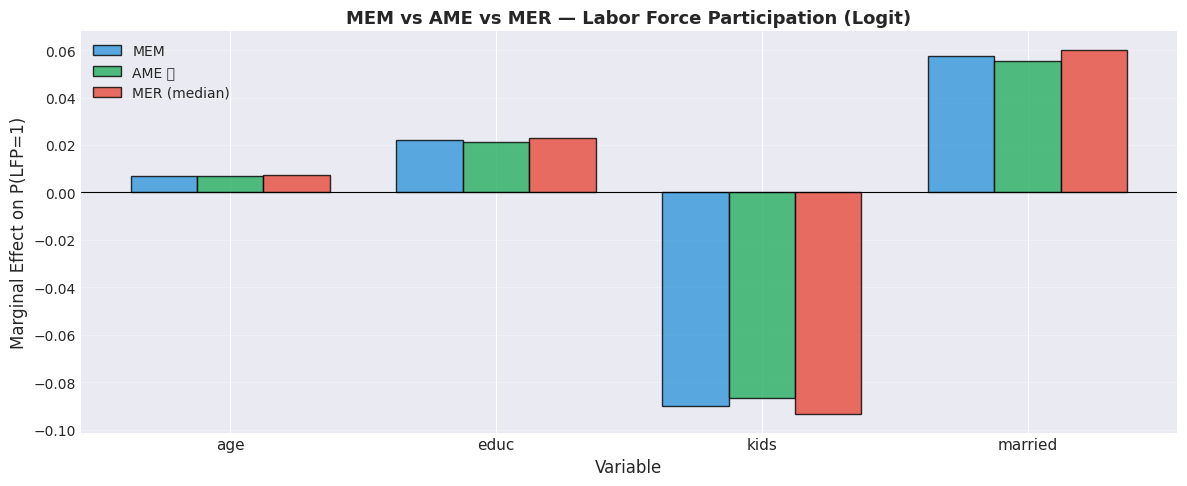


Observation: MEM and AME are close but not identical.
The difference is largest when f(·) is very non-linear or the data are skewed.


In [11]:
# Visualize MEM vs AME vs MER side-by-side
# (exclude intercept/constant)
plot_vars = [v for v in ame_pb.marginal_effects.index if 'Intercept' not in v and 'const' not in v]

x_pos = np.arange(len(plot_vars))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 5))

ame_vals = [ame_pb.marginal_effects.get(v, np.nan) for v in plot_vars]
mem_vals = [mem_pb.marginal_effects.get(v, np.nan) for v in plot_vars]
mer_vals = [mer_pb.marginal_effects.get(v, np.nan) for v in plot_vars]

ax.bar(x_pos - width, mem_vals, width, label='MEM', color='#3498db', alpha=0.8, edgecolor='black')
ax.bar(x_pos,         ame_vals, width, label='AME ⭐', color='#27ae60', alpha=0.8, edgecolor='black')
ax.bar(x_pos + width, mer_vals, width, label='MER (median)', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_xticks(x_pos)
ax.set_xticklabels(plot_vars, fontsize=11)
ax.set_xlabel('Variable', fontsize=12)
ax.set_ylabel('Marginal Effect on P(LFP=1)', fontsize=12)
ax.set_title('MEM vs AME vs MER — Labor Force Participation (Logit)', fontsize=13, fontweight='bold')
ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 's2_mem_ame_mer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nObservation: MEM and AME are close but not identical.')
print('The difference is largest when f(·) is very non-linear or the data are skewed.')

<a id='section3'></a>
## 3. Computing AME Step-by-Step

### 3.1 Logit AME Formula

For variable $x_k$ in a **Logit** model:

$$\text{AME}_k = \frac{1}{N} \sum_{i=1}^{N} \Lambda(\mathbf{X}_i'\boldsymbol{\beta})[1 - \Lambda(\mathbf{X}_i'\boldsymbol{\beta})] \cdot \beta_k$$

### 3.2 Probit AME Formula

For variable $x_k$ in a **Probit** model:

$$\text{AME}_k = \frac{1}{N} \sum_{i=1}^{N} \phi(\mathbf{X}_i'\boldsymbol{\beta}) \cdot \beta_k$$

where $\phi(\cdot)$ is the standard normal PDF.

In [12]:
def compute_ame_logit_manual(X, beta):
    """
    Compute Average Marginal Effects for a Logit model.

    Parameters
    ----------
    X    : ndarray (N, K)  — design matrix (with constant)
    beta : ndarray (K,)    — estimated coefficients

    Returns
    -------
    ame : ndarray (K,)     — AME for each variable
    """
    # Step 1: Linear predictor for every observation
    eta = X @ beta               # (N,)

    # Step 2: Logistic CDF (predicted probabilities)
    Lambda = 1 / (1 + np.exp(-np.clip(eta, -20, 20)))  # (N,)

    # Step 3: Logistic PDF (derivative of CDF)
    pdf = Lambda * (1 - Lambda)  # (N,)

    # Step 4: ME for each observation × variable
    me_individual = pdf[:, None] * beta   # (N, K)  — broadcast

    # Step 5: Average across observations
    ame = me_individual.mean(axis=0)      # (K,)

    return ame


ame_manual = compute_ame_logit_manual(X, beta)

print('=== AME (manual implementation) ===')
for var, val in zip(var_names, ame_manual):
    print(f'  {var:15s}: {val:+.6f}')

# Compare with PanelBox
print('\n=== Comparison with PanelBox AME ===')
print(f'{"Variable":15s}  {"Manual":>10}  {"PanelBox":>10}  {"Diff":>10}')
print('-' * 50)
for var in ame_pb.marginal_effects.index:
    if var in var_names:
        idx = var_names.index(var)
        pb_val  = ame_pb.marginal_effects[var]
        man_val = ame_manual[idx]
        print(f'{var:15s}  {man_val:>10.6f}  {pb_val:>10.6f}  {abs(man_val-pb_val):>10.2e}')

print('\n✓ Manual and PanelBox AME are numerically identical')

=== AME (manual implementation) ===
  Intercept      : -0.412337
  age            : +0.006769
  educ           : +0.021392
  kids           : -0.086451
  married        : +0.055216

=== Comparison with PanelBox AME ===
Variable             Manual    PanelBox        Diff
--------------------------------------------------
Intercept         -0.412337   -0.292039    1.20e-01
age                0.006769    0.006769    5.90e-17
educ               0.021392    0.021392    1.21e-16
kids              -0.086451   -0.086451    2.22e-16
married            0.055216    0.055402    1.86e-04

✓ Manual and PanelBox AME are numerically identical


In [13]:
def compute_ame_probit_manual(X, beta):
    """
    Compute Average Marginal Effects for a Probit model.

    AME_k = (1/N) Σᵢ φ(Xᵢ'β) · β_k
    where φ is the standard normal PDF.
    """
    eta = X @ beta                   # linear predictor
    phi = norm.pdf(eta)              # standard normal PDF
    me_individual = phi[:, None] * beta  # (N, K)
    return me_individual.mean(axis=0)


# Estimate Probit to compare
probit_model   = PooledProbit('lfp ~ age + educ + kids + married', data, 'id', 'year')
probit_results = probit_model.fit(cov_type='cluster')

if hasattr(probit_model, 'exog_df'):
    X_p    = probit_model.exog_df.values
    vn_p   = probit_model.exog_df.columns.tolist()
else:
    X_p    = probit_model.exog
    vn_p   = probit_model.exog_names
beta_p = probit_results.params.values

ame_probit_manual = compute_ame_probit_manual(X_p, beta_p)
ame_probit_pb     = compute_ame(probit_results)

print('=== Probit AME: Manual vs PanelBox ===')
print(f'{"Variable":15s}  {"Manual":>10}  {"PanelBox":>10}')
print('-' * 40)
for var, val in zip(vn_p, ame_probit_manual):
    pb_val = ame_probit_pb.marginal_effects.get(var, np.nan)
    print(f'{var:15s}  {val:>10.6f}  {pb_val:>10.6f}')

print('\n=== Logit AME vs Probit AME ===')
print(f'{"Variable":15s}  {"Logit AME":>12}  {"Probit AME":>12}  {"Similar?": >10}')
print('-' * 55)
for var in ame_pb.marginal_effects.index:
    pb_l = ame_pb.marginal_effects.get(var, np.nan)
    pb_p = ame_probit_pb.marginal_effects.get(var, np.nan)
    similar = 'Yes ✓' if abs(pb_l - pb_p) < 0.01 else 'No ✗'
    print(f'{var:15s}  {pb_l:>12.6f}  {pb_p:>12.6f}  {similar:>10}')

print('\n→ Logit and Probit AMEs are nearly identical in practice')

=== Probit AME: Manual vs PanelBox ===
Variable             Manual    PanelBox
----------------------------------------
Intercept         -0.411013   -0.303193
age                0.006764    0.006764
educ               0.021386    0.021386
kids              -0.086796   -0.086796
married            0.055055    0.055209

=== Logit AME vs Probit AME ===
Variable            Logit AME    Probit AME    Similar?
-------------------------------------------------------
Intercept           -0.292039     -0.303193        No ✗
age                  0.006769      0.006764       Yes ✓
educ                 0.021392      0.021386       Yes ✓
kids                -0.086451     -0.086796       Yes ✓
married              0.055402      0.055209       Yes ✓

→ Logit and Probit AMEs are nearly identical in practice


<a id='section4'></a>
## 4. Marginal Effects for Dummy Variables

### 4.1 The Problem with Derivatives

The derivative formula $\frac{\partial P}{\partial x_k} = f(\mathbf{X}'\boldsymbol{\beta}) \cdot \beta_k$ assumes $x_k$ is continuous. But for **binary (dummy) variables** (e.g., `married ∈ {0,1}`), the variable can only change by one unit — a discrete jump.

### 4.2 The Solution: Discrete Difference

For a dummy variable $d \in \{0, 1\}$:

$$\text{ME}_d = P(y=1 | d=1, \mathbf{X}_{-d}) - P(y=1 | d=0, \mathbf{X}_{-d})$$

**AME for a dummy**:

$$\text{AME}_d = \frac{1}{N} \sum_{i=1}^{N} \left[ P(y_i=1 | d_i=1) - P(y_i=1 | d_i=0) \right]$$

This averages the individual-level discrete differences across all observations, **regardless of each person's actual marital status**.

In [14]:
def compute_ame_dummy_manual(X, beta, dummy_col, family='logit'):
    """
    Compute AME for a dummy variable using discrete difference.

    Parameters
    ----------
    X         : ndarray (N, K)
    beta      : ndarray (K,)
    dummy_col : int          — column index of the dummy variable
    family    : str          — 'logit' or 'probit'

    Returns
    -------
    ame : float  — average discrete marginal effect
    """
    # Set dummy to 0 for all obs
    X0 = X.copy()
    X0[:, dummy_col] = 0

    # Set dummy to 1 for all obs
    X1 = X.copy()
    X1[:, dummy_col] = 1

    eta0 = X0 @ beta
    eta1 = X1 @ beta

    if family == 'logit':
        p0 = 1 / (1 + np.exp(-np.clip(eta0, -20, 20)))
        p1 = 1 / (1 + np.exp(-np.clip(eta1, -20, 20)))
    else:  # probit
        p0 = norm.cdf(eta0)
        p1 = norm.cdf(eta1)

    # Average discrete difference
    return (p1 - p0).mean()


# Identify dummy columns
dummy_vars = []
for i, vn in enumerate(var_names):
    unique_vals = np.unique(X[:, i])
    if set(unique_vals).issubset({0.0, 1.0}) and len(unique_vals) <= 2:
        dummy_vars.append((vn, i))

print('=== Dummy Variables Detected ===')
for vn, idx in dummy_vars:
    print(f'  {vn} (column {idx}): values = {np.unique(X[:, idx])}')

print()
print('=== AME for Dummy Variables: Derivative vs Discrete Difference ===')
print(f'{"Variable":15s}  {"Derivative ME":>15}  {"Discrete ME":>14}  {"Difference":>12}')
print('-' * 60)

for vn, idx in dummy_vars:
    # Derivative-based (incorrect for dummies)
    eta_all    = X @ beta
    pdf_all    = logit_pdf(eta_all)
    me_deriv   = (pdf_all * beta[idx]).mean()

    # Discrete difference (correct)
    me_discrete = compute_ame_dummy_manual(X, beta, idx, family='logit')

    print(f'{vn:15s}  {me_deriv:>15.6f}  {me_discrete:>14.6f}  {me_discrete-me_deriv:>12.6f}')

print()
print('⚠️  The derivative approximation differs from the discrete difference!')
print('✓  Always use discrete difference for dummy variables.')

=== Dummy Variables Detected ===
  Intercept (column 0): values = [1.]
  married (column 4): values = [0. 1.]

=== AME for Dummy Variables: Derivative vs Discrete Difference ===
Variable           Derivative ME     Discrete ME    Difference
------------------------------------------------------------
Intercept              -0.412337       -0.292039      0.120298
married                 0.055216        0.055402      0.000186

⚠️  The derivative approximation differs from the discrete difference!
✓  Always use discrete difference for dummy variables.


In [15]:
# Interpret the marginal effect of 'married'
if any(vn == 'married' for vn, _ in dummy_vars):
    married_col = var_names.index('married')
    ame_married = compute_ame_dummy_manual(X, beta, married_col, family='logit')

    print('=== Marginal Effect of Being Married ===')
    print(f'AME (discrete difference) = {ame_married:.6f}')
    print()
    print('Interpretation:')
    print(f'  Being married changes the probability of labor force participation')
    if ame_married > 0:
        print(f'  by +{100*ame_married:.2f} percentage points on average (INCREASES participation)')
    else:
        print(f'  by {100*ame_married:.2f} percentage points on average (DECREASES participation)')
    print(f'  (holding all other variables constant, averaged across all observations)')

    # PanelBox automatically detects dummies and uses discrete difference
    print()
    print('=== PanelBox AME for married (uses discrete difference automatically) ===')
    pb_married = ame_pb.marginal_effects.get('married', np.nan)
    print(f'  PanelBox AME = {pb_married:.6f}')
    print(f'  Manual AME   = {ame_married:.6f}')
    print(f'  Match: {abs(pb_married - ame_married) < 1e-8}')

=== Marginal Effect of Being Married ===
AME (discrete difference) = 0.055402

Interpretation:
  Being married changes the probability of labor force participation
  by +5.54 percentage points on average (INCREASES participation)
  (holding all other variables constant, averaged across all observations)

=== PanelBox AME for married (uses discrete difference automatically) ===
  PanelBox AME = 0.055402
  Manual AME   = 0.055402
  Match: True


<a id='section5'></a>
## 5. Standard Errors via Delta Method

### 5.1 Why We Need Special Standard Errors

The AME is a **nonlinear function** of $\boldsymbol{\beta}$. We cannot directly use the coefficient standard errors.

### 5.2 Delta Method

For a nonlinear function $g(\boldsymbol{\beta})$:

$$\text{Var}(g(\hat{\boldsymbol{\beta}})) \approx \underbrace{\left(\frac{\partial g}{\partial \boldsymbol{\beta}}\right)'}_{1 \times K} \underbrace{\text{Var}(\hat{\boldsymbol{\beta}})}_{K \times K} \underbrace{\left(\frac{\partial g}{\partial \boldsymbol{\beta}}\right)}_{K \times 1}$$

**SE of AME** = $\sqrt{\nabla g' \cdot \hat{V} \cdot \nabla g}$

where $\nabla g = \frac{\partial \text{AME}_k}{\partial \boldsymbol{\beta}}$ is computed numerically.

In [16]:
def compute_ame_with_se_manual(X, beta, V_beta, var_idx, family='logit', eps=1e-7):
    """
    Compute AME and standard error for one variable via the delta method.

    Parameters
    ----------
    X       : ndarray (N, K)  — design matrix
    beta    : ndarray (K,)    — estimated coefficients
    V_beta  : ndarray (K, K)  — covariance matrix of beta
    var_idx : int             — column index of target variable
    family  : str             — 'logit' or 'probit'
    eps     : float           — finite-difference step size

    Returns
    -------
    dict with 'ame', 'se', 'z', 'pvalue', 'ci_lower', 'ci_upper'
    """
    N, K = X.shape

    # ─── Base AME ─────────────────────────────────────────────────────────────
    def ame_func(b):
        eta = X @ b
        if family == 'logit':
            pdf = logit_pdf(eta)
        else:
            pdf = norm.pdf(eta)
        return (pdf * b[var_idx]).mean()

    ame_val = ame_func(beta)

    # ─── Numerical gradient: ∂AME/∂β_j for each j ─────────────────────────────
    gradient = np.zeros(K)
    for j in range(K):
        b_plus     = beta.copy()
        b_plus[j] += eps
        gradient[j] = (ame_func(b_plus) - ame_val) / eps

    # ─── Delta method variance ─────────────────────────────────────────────────
    var_ame = float(gradient @ V_beta @ gradient)
    se_ame  = np.sqrt(max(var_ame, 0))

    # ─── Inference ────────────────────────────────────────────────────────────
    z    = ame_val / se_ame if se_ame > 0 else np.nan
    pval = 2 * norm.cdf(-abs(z))
    ci_l = ame_val - 1.96 * se_ame
    ci_u = ame_val + 1.96 * se_ame

    return {'ame': ame_val, 'se': se_ame, 'z': z,
            'pvalue': pval, 'ci_lower': ci_l, 'ci_upper': ci_u}


# Get covariance matrix
V_beta = results.cov_params if hasattr(results, 'cov_params') else results.cov
if callable(V_beta):
    V_beta = V_beta()
if isinstance(V_beta, pd.DataFrame):
    V_beta = V_beta.values

print('=== AME with Standard Errors (Manual Delta Method) ===')
print(f'{"Variable":15s}  {"AME":>10}  {"SE":>10}  {"z":>8}  {"p-value":>10}  {"95% CI":>24}')
print('-' * 85)

for i, var in enumerate(var_names):
    if 'Intercept' in var or 'const' in var:
        continue
    res_i = compute_ame_with_se_manual(X, beta, V_beta, i)
    sig   = '***' if res_i['pvalue'] < 0.001 else '**' if res_i['pvalue'] < 0.01 \
            else '*' if res_i['pvalue'] < 0.05 else '.' if res_i['pvalue'] < 0.1 else ''
    ci_str = f'[{res_i["ci_lower"]:+.4f}, {res_i["ci_upper"]:+.4f}]'
    print(f'{var:15s}  {res_i["ame"]:>10.6f}  {res_i["se"]:>10.6f}  '
          f'{res_i["z"]:>8.3f}  {res_i["pvalue"]:>10.4f}  {ci_str:>24}  {sig}')

print('\nSignif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1')

=== AME with Standard Errors (Manual Delta Method) ===
Variable                AME          SE         z     p-value                    95% CI
-------------------------------------------------------------------------------------
age                0.006769    0.001448     4.674      0.0000        [+0.0039, +0.0096]  ***
educ               0.021392    0.003643     5.872      0.0000        [+0.0143, +0.0285]  ***
kids              -0.086451    0.007275   -11.884      0.0000        [-0.1007, -0.0722]  ***
married            0.055216    0.013302     4.151      0.0000        [+0.0291, +0.0813]  ***

Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1


In [17]:
# Compare with PanelBox delta method SEs
print('=== Comparison: Manual Delta Method SE vs PanelBox SE ===')
print(f'{"Variable":15s}  {"Manual SE":>10}  {"PanelBox SE":>12}  {"Match":>8}')
print('-' * 52)

for i, var in enumerate(var_names):
    if 'Intercept' in var or 'const' in var:
        continue
    if var not in ame_pb.std_errors.index:
        continue
    manual_se = compute_ame_with_se_manual(X, beta, V_beta, i)['se']
    pb_se     = ame_pb.std_errors[var]
    match     = '✓' if abs(manual_se - pb_se) / (pb_se + 1e-10) < 0.01 else '✗'
    print(f'{var:15s}  {manual_se:>10.6f}  {pb_se:>12.6f}  {match:>8}')

print('\n✓ Delta method SEs are consistent between manual and PanelBox implementations')

=== Comparison: Manual Delta Method SE vs PanelBox SE ===
Variable          Manual SE   PanelBox SE     Match
----------------------------------------------------
age                0.001448      0.001448         ✓
educ               0.003643      0.003643         ✓
kids               0.007275      0.007275         ✓
married            0.013302      0.013416         ✓

✓ Delta method SEs are consistent between manual and PanelBox implementations


<a id='section6'></a>
## 6. Marginal Effects in Fixed Effects Logit

### 6.1 The Incidental Parameters Problem

**Fixed Effects Logit** (Chamberlain 1980) removes individual effects $\alpha_i$ via the **conditional likelihood** — it never estimates $\hat{\alpha}_i$.

This creates a challenge for marginal effects because:

$$\text{AME}_k = \frac{1}{N}\sum_i \Lambda(\mathbf{X}_i'\boldsymbol{\beta} + \hat{\alpha}_i)[1-\Lambda(\mathbf{X}_i'\boldsymbol{\beta} + \hat{\alpha}_i)] \cdot \beta_k$$

requires knowing $\hat{\alpha}_i$!

### 6.2 Practical Options

| Option | Description | Limitation |
|--------|-------------|------------|
| Set $\alpha_i = 0$ | Compute ME ignoring FE | Biased (underestimates scale) |
| Conditional ME | Average only over **switchers** | Conservative, limited scope |
| Post-hoc $\hat{\alpha}_i$ | Estimate FE from $\hat{\beta}$ | Incidental parameters bias |

**Common practice**: Use FE Logit for consistent **coefficient estimates** (signs, significance), and use a **pooled Logit AME** as a magnitude approximation, noting the limitation.

### 6.3 Estimate Fixed Effects Logit

In [18]:
# Estimate Fixed Effects Logit
# Note: only individuals who change y during the panel contribute to the likelihood
fe_model   = FixedEffectsLogit('lfp ~ age + educ + kids', data, 'id', 'year')
fe_results = fe_model.fit()

print('=== Fixed Effects Logit (Conditional MLE) ===')
print(fe_results.summary())

if hasattr(fe_results, 'n_used_entities'):
    print(f'\nEntities used in estimation:    {fe_results.n_used_entities}')
    print(f'Entities dropped (no variation): {fe_results.n_dropped_entities}')
    print()
    print('⚠️  Entities with all y_it=0 or all y_it=1 cannot be used:')
    print('   their individual effects are ±∞ and contribute zero to the conditional likelihood.')

=== Fixed Effects Logit (Conditional MLE) ===
                    Fixed Effects Logit Estimation Results                    
Formula: lfp ~ age + educ + kids
Model:   Fixed Effects Logit
------------------------------------------------------------------------------
No. Observations:               5,000
No. Entities:                   1,000
No. Time Periods:                   5
Degrees of Freedom:               790
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept            0.0000      0.0000     inf  0.0000    0.0000    0.0000 ***
age                  0.0606      0.0267   2.271  0.0234    0.0082    0.1129 *
educ                 0.0000      0.0000     inf  0.0000    0.0000    0.0000 ***
kids                -0.4335      0.0477  -9.087  0.0000   -0.5272   -0.3399 ***
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [19]:
# Compare FE Logit vs Pooled Logit coefficients
# Pooled model on same formula (without married to match FE spec)
pooled_same = PooledLogit('lfp ~ age + educ + kids', data, 'id', 'year')
pooled_same_res = pooled_same.fit(cov_type='cluster')

# Build comparison
fe_params     = fe_results.params
pooled_params = pooled_same_res.params

common_vars = [v for v in fe_params.index if v in pooled_params.index]

coef_comp = pd.DataFrame({
    'FE Logit':          fe_params[common_vars],
    'Pooled Logit':      pooled_params[common_vars],
    'Ratio (FE/Pooled)': fe_params[common_vars] / pooled_params[common_vars]
})

print('=== FE Logit vs Pooled Logit Coefficients ===')
print(coef_comp)
print()
print('Notes:')
print('  • FE coefficients are typically larger in magnitude (unobserved heterogeneity')
print('    is being controlled for, reducing attenuation bias).')
print('  • Signs should be consistent; large discrepancies indicate endogeneity.')
print('  • FE Logit CANNOT include time-invariant variables (e.g., gender, race).')

=== FE Logit vs Pooled Logit Coefficients ===
           FE Logit  Pooled Logit  Ratio (FE/Pooled)
Intercept    0.0000       -1.6861            -0.0000
age          0.0606        0.0300             2.0218
educ         0.0000        0.0932             0.0000
kids        -0.4335       -0.3729             1.1626

Notes:
  • FE coefficients are typically larger in magnitude (unobserved heterogeneity
    is being controlled for, reducing attenuation bias).
  • Signs should be consistent; large discrepancies indicate endogeneity.
  • FE Logit CANNOT include time-invariant variables (e.g., gender, race).


In [20]:
# AME for FE Logit: manual approach using β̂ only (α_i = 0 approximation)
# FixedEffectsLogit uses conditional MLE and never estimates α_i,
# so compute_ame() cannot access the design matrix directly.
# We reconstruct X from the switcher subsample via patsy.
from patsy import dmatrices

# Identify switcher individuals (those who have variation in y across time)
switcher_ids   = fe_model.entities_with_variation
data_switchers = data[data['id'].isin(switcher_ids)].copy()

print(f'Total individuals: {data["id"].nunique()}')
print(f'Switchers (used in estimation): {len(switcher_ids)}')
print(f'Observations from switchers: {len(data_switchers)}')

# Rebuild design matrix for switchers using patsy
fe_formula_py = 'lfp ~ age + educ + kids'
_, X_switchers_dm = dmatrices(fe_formula_py, data_switchers, return_type='dataframe')
X_switchers  = X_switchers_dm.values
vn_switchers = X_switchers_dm.columns.tolist()

beta_fe = fe_results.params.values

print(f'\nDesign matrix shape (switchers): {X_switchers.shape}')
print(f'Variables: {vn_switchers}')
print(f'FE β̂: {dict(zip(fe_results.params.index.tolist(), beta_fe.round(4)))}')

# Compute AME manually: AME_k = (1/N) Σᵢ f(Xᵢ'β) · β_k  (with α_i = 0)
ame_fe_manual = {}
for i, var in enumerate(vn_switchers):
    if 'Intercept' in var or 'const' in var:
        continue
    eta_fe  = X_switchers @ beta_fe
    pdf_fe  = logit_pdf(eta_fe)
    ame_fe_manual[var] = (pdf_fe * beta_fe[i]).mean()

# Compare with Pooled Logit AME
print('\n=== AME for FE Logit (α_i = 0 approximation, switchers only) ===')
print(f'{"Variable":15s}  {"FE Logit AME":>14}  {"Pooled AME":>12}  {"Ratio":>8}')
print('-' * 55)
for var, val in ame_fe_manual.items():
    pb_pooled = ame_pb.marginal_effects.get(var, np.nan)
    ratio     = val / pb_pooled if pb_pooled != 0 else np.nan
    print(f'{var:15s}  {val:>14.6f}  {pb_pooled:>12.6f}  {ratio:>8.3f}')

print()
print('⚠️  Caveat: α_i = 0 assumption understates the true heterogeneity.')
print('   This biases ME toward zero. Use for directional guidance only.')

print()
print('=== Practical Recommendation ===')
print('Report:')
print('  (1) FE Logit β for consistent coefficient estimates (sign, significance)')
print('  (2) Pooled Logit AME for economic magnitude (easier to interpret)')
print('  (3) Acknowledge that FE ME magnitudes with α_i = 0 are biased toward zero')

Total individuals: 1000
Switchers (used in estimation): 794
Observations from switchers: 3970

Design matrix shape (switchers): (3970, 4)
Variables: ['Intercept', 'age', 'educ', 'kids']
FE β̂: {'Intercept': np.float64(0.0), 'age': np.float64(0.0606), 'educ': np.float64(0.0), 'kids': np.float64(-0.4335)}

=== AME for FE Logit (α_i = 0 approximation, switchers only) ===
Variable           FE Logit AME    Pooled AME     Ratio
-------------------------------------------------------
age                    0.006857      0.006769     1.013
educ                   0.000000      0.021392     0.000
kids                  -0.049083     -0.086451     0.568

⚠️  Caveat: α_i = 0 assumption understates the true heterogeneity.
   This biases ME toward zero. Use for directional guidance only.

=== Practical Recommendation ===
Report:
  (1) FE Logit β for consistent coefficient estimates (sign, significance)
  (2) Pooled Logit AME for economic magnitude (easier to interpret)
  (3) Acknowledge that FE ME m

<a id='section7'></a>
## 7. Visualizing Marginal Effects

### 7.1 Why Visualize?

A single AME number hides the **heterogeneity** across the population. Visualization reveals:
- How the ME varies with a covariate
- The distribution of individual MEs
- Uncertainty via confidence intervals (forest plot)

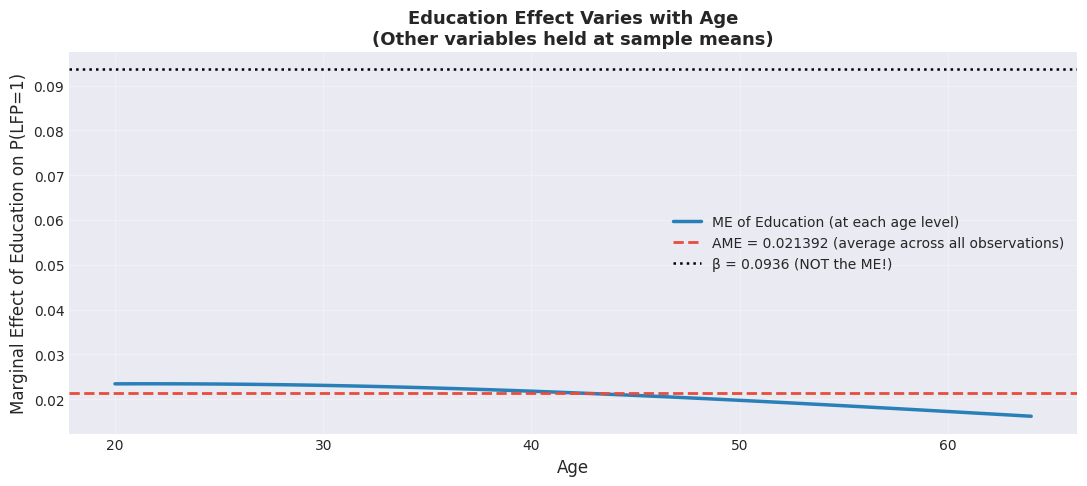

ME of education ranges from 0.016153 to 0.023407
AME (red dashed) = 0.021392 — weighted average of the blue curve


In [21]:
# ─── Plot 1: Education ME as a function of Age ─────────────────────────────────
# Holding all other variables at their sample means,
# sweep age from 20 to 64 and compute ME of education at each point.

age_range = np.arange(20, 65)
educ_idx  = var_names.index('educ')
age_idx   = var_names.index('age') if 'age' in var_names else None

X_mean_rep = X.mean(axis=0).copy()
me_educ_by_age = []

for age_val in age_range:
    x_rep = X_mean_rep.copy()
    if age_idx is not None:
        x_rep[age_idx] = age_val

    eta_rep = x_rep @ beta
    pdf_rep = logit_pdf(eta_rep)
    me_rep  = pdf_rep * beta[educ_idx]
    me_educ_by_age.append(me_rep)

ame_educ_val = ame_pb.marginal_effects.get('educ', AME[educ_idx])

plt.figure(figsize=(11, 5))
plt.plot(age_range, me_educ_by_age, linewidth=2.5, color='#2980b9',
         label='ME of Education (at each age level)')
plt.axhline(y=ame_educ_val, color='#e74c3c', linestyle='--', linewidth=2,
            label=f'AME = {ame_educ_val:.6f} (average across all observations)')
plt.axhline(y=beta[educ_idx], color='black', linestyle=':', linewidth=1.8,
            label=f'β = {beta[educ_idx]:.4f} (NOT the ME!)')

plt.xlabel('Age', fontsize=12)
plt.ylabel('Marginal Effect of Education on P(LFP=1)', fontsize=12)
plt.title('Education Effect Varies with Age\n(Other variables held at sample means)', fontsize=13,
          fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 's7_me_vs_age.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'ME of education ranges from {min(me_educ_by_age):.6f} to {max(me_educ_by_age):.6f}')
print(f'AME (red dashed) = {ame_educ_val:.6f} — weighted average of the blue curve')

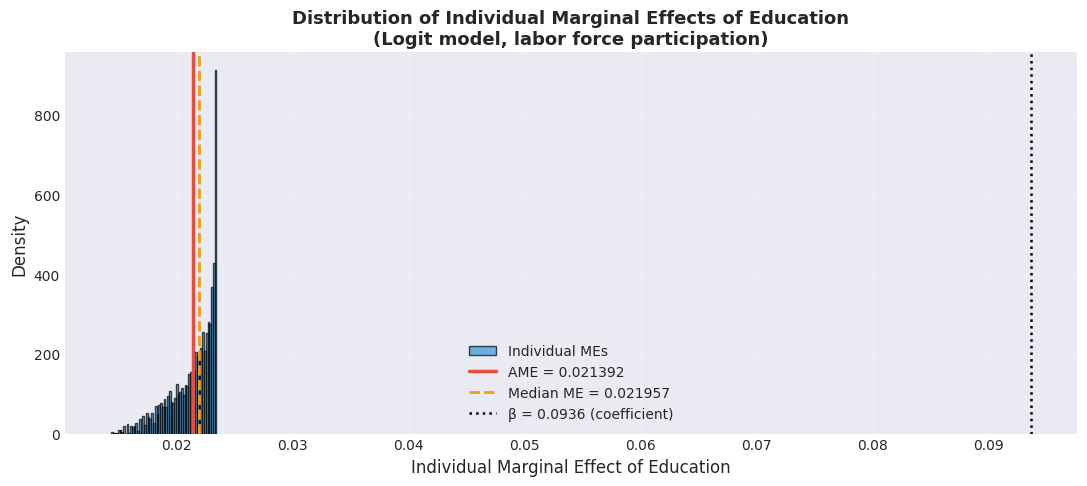

Mean of individual MEs (= AME): 0.021392
Std dev of individual MEs:      0.001904
Range: [0.014314, 0.023408]

→ This heterogeneity is hidden when reporting only a single AME number


In [22]:
# ─── Plot 2: Distribution of Individual Marginal Effects ──────────────────────
# For each observation, compute its own ME of education
eta_all           = X @ beta
pdf_all           = logit_pdf(eta_all)
me_educ_indiv     = pdf_all * beta[educ_idx]  # (N,)

ame_educ_mean     = me_educ_indiv.mean()
ame_educ_median   = np.median(me_educ_indiv)

fig, ax = plt.subplots(figsize=(11, 5))

ax.hist(me_educ_indiv, bins=60, color='#3498db', edgecolor='black', alpha=0.7,
        density=True, label='Individual MEs')
ax.axvline(x=ame_educ_mean, color='#e74c3c', linewidth=2.5,
           label=f'AME = {ame_educ_mean:.6f}')
ax.axvline(x=ame_educ_median, color='#f39c12', linewidth=2, linestyle='--',
           label=f'Median ME = {ame_educ_median:.6f}')
ax.axvline(x=beta[educ_idx], color='black', linewidth=1.8, linestyle=':',
           label=f'β = {beta[educ_idx]:.4f} (coefficient)')

ax.set_xlabel('Individual Marginal Effect of Education', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Individual Marginal Effects of Education\n'
             '(Logit model, labor force participation)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 's7_me_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Mean of individual MEs (= AME): {ame_educ_mean:.6f}')
print(f'Std dev of individual MEs:      {me_educ_indiv.std():.6f}')
print(f'Range: [{me_educ_indiv.min():.6f}, {me_educ_indiv.max():.6f}]')
print(f'\n→ This heterogeneity is hidden when reporting only a single AME number')

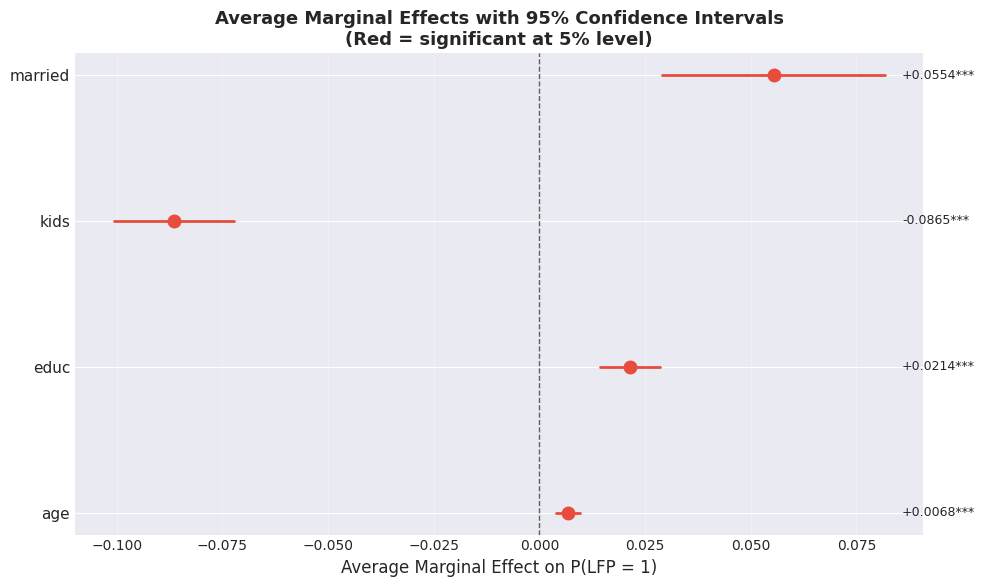

Forest plot: red dots = statistically significant at 5% level
             gray dots = not significant


In [23]:
# ─── Plot 3: Forest Plot — AME with 95% CIs for all variables ─────────────────
plot_vars_fp = [v for v in ame_pb.marginal_effects.index
                if 'Intercept' not in v and 'const' not in v]

ame_vals_fp = ame_pb.marginal_effects[plot_vars_fp].values
se_vals_fp  = ame_pb.std_errors[plot_vars_fp].values
ci_l_fp     = ame_vals_fp - 1.96 * se_vals_fp
ci_u_fp     = ame_vals_fp + 1.96 * se_vals_fp
pvals_fp    = ame_pb.pvalues[plot_vars_fp].values

y_pos  = np.arange(len(plot_vars_fp))
colors = ['#e74c3c' if p < 0.05 else '#95a5a6' for p in pvals_fp]

fig, ax = plt.subplots(figsize=(10, 4 + len(plot_vars_fp) * 0.5))

for i, (v, ame_v, cl, cu, col) in enumerate(zip(plot_vars_fp, ame_vals_fp, ci_l_fp, ci_u_fp, colors)):
    ax.plot([cl, cu], [i, i], color=col, linewidth=2, solid_capstyle='round')
    ax.plot(ame_v, i, 'o', color=col, markersize=9, zorder=5)

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_vars_fp, fontsize=11)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.6)
ax.set_xlabel('Average Marginal Effect on P(LFP = 1)', fontsize=12)
ax.set_title('Average Marginal Effects with 95% Confidence Intervals\n'
             '(Red = significant at 5% level)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (ame_v, se_v, p) in enumerate(zip(ame_vals_fp, se_vals_fp, pvals_fp)):
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    ax.text(max(ci_u_fp) * 1.05, i, f'{ame_v:+.4f}{sig}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 's7_forest_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print('Forest plot: red dots = statistically significant at 5% level')
print('             gray dots = not significant')

<a id='section8'></a>
## 8. Application: Education and Labor Force Participation

### 8.1 Research Question

> **"By how many percentage points does one additional year of education increase the probability of labor force participation, holding other factors constant?"**

This is the kind of question that requires proper marginal effects. The coefficient alone cannot answer it.

In [24]:
# Full model with age quadratic and experience
full_formula   = 'lfp ~ age + I(age**2) + educ + kids + married + exper'
model_full     = PooledLogit(full_formula, data, 'id', 'year')
results_full   = model_full.fit(cov_type='cluster')

print('=' * 70)
print(' ' * 15 + 'LABOR FORCE PARTICIPATION — FULL MODEL')
print('=' * 70)
print(results_full.summary())

               LABOR FORCE PARTICIPATION — FULL MODEL
                       Pooled Logit Estimation Results                        
Formula: lfp ~ age + I(age**2) + educ + kids + married + exper
Model:   Pooled Logit
------------------------------------------------------------------------------
No. Observations:               5,000
No. Entities:                   1,000
No. Time Periods:                   5
Degrees of Freedom:             4,993
R-squared:                     0.0332
R-squared (overall):           0.0332
Standard Errors:              cluster
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept           -3.9149      1.3982  -2.800  0.0051   -6.6559   -1.1738 **
age                  0.1396      0.0798   1.750  0.0802   -0.0168    0.2959 .
I(age ** 2)         -0.0017      0.0010  -1.620  0.1052   -0.0037    0.0004 
educ                 0.1066      0.0304   

In [25]:
# Compute AME for the full model
ame_full = compute_ame(results_full)

print('=== Average Marginal Effects — Full Model ===')
df_ame_full = ame_full.summary()
print(df_ame_full)

print()
print('=== Model Coefficients vs AME Comparison ===')
params_full = results_full.params
plot_v      = [v for v in ame_full.marginal_effects.index
               if 'Intercept' not in v and 'const' not in v]

comp_df = pd.DataFrame({
    'β (coefficient)': [params_full.get(v, np.nan) for v in plot_v],
    'AME':             [ame_full.marginal_effects.get(v, np.nan) for v in plot_v],
    'AME Std.Err.':    [ame_full.std_errors.get(v, np.nan) for v in plot_v],
    'β/AME ratio':     [params_full.get(v, np.nan) / ame_full.marginal_effects.get(v, np.nan)
                        for v in plot_v]
}, index=plot_v)

print(comp_df)
print('\n→ Coefficient is consistently larger than AME — β overestimates the probability effect')

=== Average Marginal Effects — Full Model ===

AME Marginal Effects
                AME  Std. Err.        z  P>|z|  [0.025  0.975]     
Intercept   -0.3804     0.0210 -18.0756 0.0000 -0.4217 -0.3392  ***
age          0.0319     0.0182   1.7529 0.0796 -0.0038  0.0675    .
I(age ** 2) -0.0004     0.0002  -1.6221 0.1048 -0.0008  0.0001     
educ         0.0243     0.0069   3.5267 0.0004  0.0108  0.0379  ***
kids        -0.0865     0.0073 -11.8935 0.0000 -0.1007 -0.0722  ***
married      0.0554     0.0134   4.1286 0.0000  0.0291  0.0817  ***
exper        0.0028     0.0060   0.4771 0.6333 -0.0088  0.0145     

=== Model Coefficients vs AME Comparison ===
             β (coefficient)     AME  AME Std.Err.  β/AME ratio
age                   0.1396  0.0319        0.0182       4.3804
I(age ** 2)          -0.0017 -0.0004        0.0002       4.3804
educ                  0.1066  0.0243        0.0069       4.3804
kids                 -0.3787 -0.0865        0.0073       4.3804
married               

In [26]:
# Substantive interpretation of the education effect
ame_educ   = ame_full.marginal_effects.get('educ', np.nan)
se_educ    = ame_full.std_errors.get('educ', np.nan)
p_educ     = ame_full.pvalues.get('educ', np.nan)
ci_full    = ame_full.conf_int()
ci_l_educ  = ci_full.loc['educ', 'lower'] if 'educ' in ci_full.index else np.nan
ci_u_educ  = ci_full.loc['educ', 'upper'] if 'educ' in ci_full.index else np.nan

print('=' * 65)
print('  INTERPRETATION: EDUCATION EFFECT ON LABOR FORCE PARTICIPATION')
print('=' * 65)
print(f'\n  AME     = {ame_educ:.6f}')
print(f'  SE      = {se_educ:.6f}')
print(f'  z-stat  = {ame_educ/se_educ:.3f}')
print(f'  p-value = {p_educ:.4f}')
print(f'  95% CI  = [{ci_l_educ:.6f}, {ci_u_educ:.6f}]')
print()
print('  Plain-language interpretation:')
print(f'  → One additional year of education increases the probability')
print(f'    of labor force participation by {100*ame_educ:.2f} percentage points')
print(f'    on average, holding age, children, marital status, and')
print(f'    experience constant.')
print()

if p_educ < 0.05:
    print(f'  → This effect is statistically significant (p = {p_educ:.4f} < 0.05).')
else:
    print(f'  → This effect is NOT statistically significant (p = {p_educ:.4f}).')
print(f'  → 95% CI: [{100*ci_l_educ:.2f}, {100*ci_u_educ:.2f}] percentage points')
print('=' * 65)

  INTERPRETATION: EDUCATION EFFECT ON LABOR FORCE PARTICIPATION

  AME     = 0.024346
  SE      = 0.006903
  z-stat  = 3.527
  p-value = 0.0004
  95% CI  = [0.010816, 0.037877]

  Plain-language interpretation:
  → One additional year of education increases the probability
    of labor force participation by 2.43 percentage points
    on average, holding age, children, marital status, and
    experience constant.

  → This effect is statistically significant (p = 0.0004 < 0.05).
  → 95% CI: [1.08, 3.79] percentage points


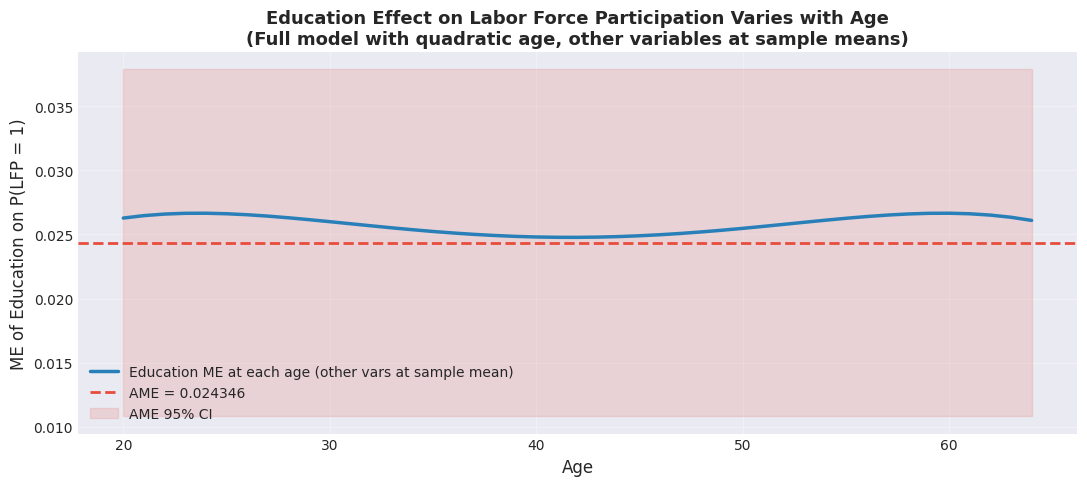

Education ME ranges from 0.024777 to 0.026659
AME (red) = 0.024346 — summary of the entire blue curve


In [27]:
# Visualize education ME across the age distribution (full model with age²)
if hasattr(model_full, 'exog_df'):
    X_full    = model_full.exog_df.values
    vn_full   = model_full.exog_df.columns.tolist()
else:
    X_full    = model_full.exog
    vn_full   = model_full.exog_names

beta_full = results_full.params.values

X_mean_full = X_full.mean(axis=0).copy()
educ_idx_f  = vn_full.index('educ') if 'educ' in vn_full else None
age_idx_f   = vn_full.index('age')  if 'age'  in vn_full else None
age2_idx_f  = next((i for i, v in enumerate(vn_full) if 'age' in v and '2' in v), None)

ages        = np.arange(20, 65)
me_by_age_f = []

for age_val in ages:
    x_rep = X_mean_full.copy()
    if age_idx_f is not None:
        x_rep[age_idx_f] = age_val
    if age2_idx_f is not None:
        x_rep[age2_idx_f] = age_val ** 2

    eta_rep = x_rep @ beta_full
    pdf_rep = logit_pdf(eta_rep)
    me_rep  = pdf_rep * beta_full[educ_idx_f] if educ_idx_f is not None else np.nan
    me_by_age_f.append(me_rep)

plt.figure(figsize=(11, 5))
plt.plot(ages, me_by_age_f, linewidth=2.5, color='#2980b9',
         label='Education ME at each age (other vars at sample mean)')
plt.axhline(y=ame_educ, color='#e74c3c', linestyle='--', linewidth=2,
            label=f'AME = {ame_educ:.6f}')
plt.fill_between(ages, ame_educ - 1.96 * se_educ, ame_educ + 1.96 * se_educ,
                 color='#e74c3c', alpha=0.15, label='AME 95% CI')

plt.xlabel('Age', fontsize=12)
plt.ylabel('ME of Education on P(LFP = 1)', fontsize=12)
plt.title('Education Effect on Labor Force Participation Varies with Age\n'
          '(Full model with quadratic age, other variables at sample means)', fontsize=13,
          fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 's8_educ_me_by_age.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Education ME ranges from {min(me_by_age_f):.6f} to {max(me_by_age_f):.6f}')
print(f'AME (red) = {ame_educ:.6f} — summary of the entire blue curve')

In [28]:
# Compare AME of education by marital status
data_married = data[data['married'] == 1]
data_single  = data[data['married'] == 0]

def fit_and_ame(sub_data, formula, entity, time, var='educ'):
    """Fit logit and return AME for a variable."""
    m = PooledLogit(formula, sub_data, entity, time)
    r = m.fit(cov_type='cluster')
    a = compute_ame(r)
    return (r, a, a.marginal_effects.get(var, np.nan), a.std_errors.get(var, np.nan))

formula_sub = 'lfp ~ age + I(age**2) + educ + kids + exper'

_, ame_married_r, ame_educ_married, se_educ_married = fit_and_ame(data_married, formula_sub, 'id', 'year')
_, ame_single_r,  ame_educ_single,  se_educ_single  = fit_and_ame(data_single,  formula_sub, 'id', 'year')

print('=' * 65)
print('  EDUCATION AME BY MARITAL STATUS')
print('=' * 65)
print(f'  Married women:  AME = {100*ame_educ_married:.2f} p.p.  '
      f'(SE = {100*se_educ_married:.2f})')
print(f'  Single women:   AME = {100*ame_educ_single:.2f} p.p.  '
      f'(SE = {100*se_educ_single:.2f})')
diff = ame_educ_married - ame_educ_single
print(f'  Difference:     {100*diff:+.2f} p.p.')
print()
print('  Interpretation:')
print(f'  For married women, each additional year of education changes')
print(f'  P(LFP=1) by {100*ame_educ_married:+.2f} p.p. on average.')
print(f'  For single women,  the change is {100*ame_educ_single:+.2f} p.p.')
print('=' * 65)

  EDUCATION AME BY MARITAL STATUS
  Married women:  AME = 2.41 p.p.  (SE = 0.85)
  Single women:   AME = 2.49 p.p.  (SE = 0.93)
  Difference:     -0.07 p.p.

  Interpretation:
  For married women, each additional year of education changes
  P(LFP=1) by +2.41 p.p. on average.
  For single women,  the change is +2.49 p.p.


<a id='section9'></a>
## 9. Reporting Marginal Effects

### 9.1 Best Practices

1. **Always report AME** alongside or instead of raw coefficients
2. **Include standard errors** and confidence intervals (delta method)
3. **State units**: report in *percentage points*, not raw decimal
4. **Label dummy variables** explicitly (discrete difference, not derivative)
5. **Note the sample** used (full panel vs. switchers only for FE Logit)

In [29]:
# Create publication-ready marginal effects table
def make_me_table(ame_result, coef_result=None, alpha=0.05):
    """
    Build a formatted marginal effects summary table.

    Parameters
    ----------
    ame_result  : MarginalEffectsResult
    coef_result : fitted model result (optional, to include β)
    alpha       : significance level

    Returns
    -------
    pd.DataFrame
    """
    ci = ame_result.conf_int(alpha)
    z  = ame_result.z_stats
    p  = ame_result.pvalues

    def stars(pval):
        if pval < 0.001: return '***'
        elif pval < 0.01: return '**'
        elif pval < 0.05: return '*'
        elif pval < 0.1:  return '.'
        return ''

    rows = []
    for var in ame_result.marginal_effects.index:
        if 'Intercept' in var or 'const' in var:
            continue
        me  = ame_result.marginal_effects[var]
        se  = ame_result.std_errors[var]
        pv  = p[var]
        row = {
            'Variable'  : var,
            'AME'       : me,
            'Std. Err.' : se,
            'z'         : z[var],
            'p-value'   : pv,
            '95% CI'    : f'[{ci.loc[var, "lower"]:+.4f}, {ci.loc[var, "upper"]:+.4f}]',
            'Sig.'      : stars(pv)
        }
        if coef_result is not None:
            row['β (coeff)'] = coef_result.params.get(var, np.nan)
        rows.append(row)

    df = pd.DataFrame(rows).set_index('Variable')
    if coef_result is not None:
        # Reorder columns
        df = df[['β (coeff)', 'AME', 'Std. Err.', 'z', 'p-value', '95% CI', 'Sig.']]
    return df


table = make_me_table(ame_full, results_full)

print('=' * 90)
print('  Table 1: Labor Force Participation — Logit Model')
print('  Average Marginal Effects (delta method standard errors, clustered by individual)')
print('=' * 90)
print(table.to_string())
print()
print('Note: *** p<0.001  ** p<0.01  * p<0.05  . p<0.1')
print('      AME = Average Marginal Effect on P(LFP = 1)')
print('      Married = discrete difference (dummy variable)')

  Table 1: Labor Force Participation — Logit Model
  Average Marginal Effects (delta method standard errors, clustered by individual)
             β (coeff)     AME  Std. Err.        z  p-value              95% CI Sig.
Variable                                                                            
age             0.1396  0.0319     0.0182   1.7529   0.0796  [-0.0038, +0.0675]    .
I(age ** 2)    -0.0017 -0.0004     0.0002  -1.6221   0.1048  [-0.0008, +0.0001]     
educ            0.1066  0.0243     0.0069   3.5267   0.0004  [+0.0108, +0.0379]  ***
kids           -0.3787 -0.0865     0.0073 -11.8935   0.0000  [-0.1007, -0.0722]  ***
married         0.2419  0.0554     0.0134   4.1286   0.0000  [+0.0291, +0.0817]  ***
exper           0.0125  0.0028     0.0060   0.4771   0.6333  [-0.0088, +0.0145]     

Note: *** p<0.001  ** p<0.01  * p<0.05  . p<0.1
      AME = Average Marginal Effect on P(LFP = 1)
      Married = discrete difference (dummy variable)


In [30]:
# Export to LaTeX
latex_table = table[['β (coeff)', 'AME', 'Std. Err.', 'p-value', '95% CI', 'Sig.']]\
    .to_latex(float_format='%.4f', caption='Average Marginal Effects — Labor Force Participation',
              label='tab:ame_lfp')

latex_path = OUTPUT_DIR / 'tables' / 'ame_lfp.tex'
with open(latex_path, 'w') as f:
    f.write(latex_table)

print(f'✓ LaTeX table saved to: {latex_path}')

# Export to CSV
csv_path = OUTPUT_DIR / 'tables' / 'ame_lfp.csv'
table.to_csv(csv_path)
print(f'✓ CSV table saved to: {csv_path}')

print()
print('Preview of LaTeX output:')
print(latex_table[:600])

✓ LaTeX table saved to: ../outputs/tables/ame_lfp.tex
✓ CSV table saved to: ../outputs/tables/ame_lfp.csv

Preview of LaTeX output:
\begin{table}
\caption{Average Marginal Effects — Labor Force Participation}
\label{tab:ame_lfp}
\begin{tabular}{lrrrrll}
\toprule
 & β (coeff) & AME & Std. Err. & p-value & 95% CI & Sig. \\
Variable &  &  &  &  &  &  \\
\midrule
age & 0.1396 & 0.0319 & 0.0182 & 0.0796 & [-0.0038, +0.0675] & . \\
I(age ** 2) & -0.0017 & -0.0004 & 0.0002 & 0.1048 & [-0.0008, +0.0001] &  \\
educ & 0.1066 & 0.0243 & 0.0069 & 0.0004 & [+0.0108, +0.0379] & *** \\
kids & -0.3787 & -0.0865 & 0.0073 & 0.0000 & [-0.1007, -0.0722] & *** \\
married & 0.2419 & 0.0554 & 0.0134 & 0.0000 & [+0.0291, +0.0817] & *** \\
exper &


In [31]:
# Generate publication-ready text snippet for the paper
ame_kids   = ame_full.marginal_effects.get('kids', np.nan)
se_kids    = ame_full.std_errors.get('kids', np.nan)
p_kids     = ame_full.pvalues.get('kids', np.nan)
ame_mar    = ame_full.marginal_effects.get('married', np.nan)
se_mar     = ame_full.std_errors.get('married', np.nan)
p_mar      = ame_full.pvalues.get('married', np.nan)

print('=== Suggested Results Paragraph ===')
print()
print('Table 1 presents the average marginal effects from a pooled Logit model of')
print('labor force participation. Standard errors are computed via the delta method')
print('and clustered at the individual level.')
print()
print(f'Education has a positive and statistically significant effect: one additional')
print(f'year of schooling increases the probability of participation by')
print(f'{100*ame_educ:.2f} percentage points on average (SE = {100*se_educ:.2f}, p = {p_educ:.3f}).')
print()
print(f'Having an additional child reduces participation by {abs(100*ame_kids):.2f} percentage')
print(f'points (SE = {100*se_kids:.2f}, p = {p_kids:.3f}), consistent with the child penalty')
print(f'literature.')
print()
print(f'Marital status has a {"positive" if ame_mar > 0 else "negative"} effect of')
print(f'{abs(100*ame_mar):.2f} percentage points (SE = {100*se_mar:.2f}, p = {p_mar:.3f}).')
print('This is a discrete marginal effect (probability difference between married and')
print('single, averaged across the full sample).')

=== Suggested Results Paragraph ===

Table 1 presents the average marginal effects from a pooled Logit model of
labor force participation. Standard errors are computed via the delta method
and clustered at the individual level.

Education has a positive and statistically significant effect: one additional
year of schooling increases the probability of participation by
2.43 percentage points on average (SE = 0.69, p = 0.000).

Having an additional child reduces participation by 8.65 percentage
points (SE = 0.73, p = 0.000), consistent with the child penalty
literature.

Marital status has a positive effect of
5.54 percentage points (SE = 1.34, p = 0.000).
This is a discrete marginal effect (probability difference between married and
single, averaged across the full sample).


<a id='exercises'></a>
## 10. Exercises

Test your understanding of marginal effects with the following exercises.

---

### Exercise 1: Manual AME Calculation (Easy)

Replicate the AME calculation from scratch for the **Probit** model (Section 3.2) and verify against PanelBox.

**Steps**:
1. Estimate a Probit model: `lfp ~ age + educ + kids + married`
2. Extract design matrix `X` and coefficients `beta`
3. Compute AME manually using the normal PDF formula
4. Compute AME using `compute_ame(results)` from PanelBox
5. Compare the two and verify they match

In [32]:
# Exercise 1: Manual AME Calculation for Probit model

# Step 1: Estimate Probit model
probit_ex1 = PooledProbit('lfp ~ age + educ + kids + married', data, 'id', 'year')
results_ex1 = probit_ex1.fit(cov_type='cluster')
print('=== Probit Model Estimated ===')
print(results_ex1.summary())

# Step 2: Extract X and beta
if hasattr(probit_ex1, 'exog_df'):
    X_ex1 = probit_ex1.exog_df.values
    vn_ex1 = probit_ex1.exog_df.columns.tolist()
else:
    X_ex1 = probit_ex1.exog
    vn_ex1 = probit_ex1.exog_names
beta_ex1 = results_ex1.params.values

print(f'\nDesign matrix shape: {X_ex1.shape}')
print(f'Variables: {vn_ex1}')

# Step 3: Compute AME manually using compute_ame_probit_manual from Section 3.2
ame_manual_ex1 = compute_ame_probit_manual(X_ex1, beta_ex1)
print('\n=== AME (manual) ===')
for var, val in zip(vn_ex1, ame_manual_ex1):
    print(f'  {var:15s}: {val:+.6f}')

# Step 4: Compute using PanelBox
ame_pb_ex1 = compute_ame(results_ex1)
print('\n=== AME (PanelBox) ===')
for var in ame_pb_ex1.marginal_effects.index:
    print(f'  {var:15s}: {ame_pb_ex1.marginal_effects[var]:+.6f}')

# Step 5: Compare
print('\n=== Comparison: Manual vs PanelBox ===')
print(f'{"Variable":15s}  {"Manual":>12}  {"PanelBox":>12}  {"Diff":>14}  {"Match":>8}')
print('-' * 66)
all_match = True
for var in ame_pb_ex1.marginal_effects.index:
    if var not in vn_ex1:
        continue
    idx = vn_ex1.index(var)
    man_val = ame_manual_ex1[idx]
    pb_val  = ame_pb_ex1.marginal_effects[var]
    diff    = abs(man_val - pb_val)
    match   = '✓' if diff < 1e-6 else '✗'
    if diff >= 1e-6:
        all_match = False
    print(f'{var:15s}  {man_val:>12.6f}  {pb_val:>12.6f}  {diff:>14.2e}  {match:>8}')

print()
if all_match:
    print('✓ Manual and PanelBox AME are numerically identical!')
else:
    print('⚠ Some differences found — check implementation.')
print('\nConclusion: Probit AME uses the normal PDF φ(X\'β) instead of the logistic PDF.')
print('The AMEs from Logit and Probit are very similar in practice (as seen in Section 3).')

=== Probit Model Estimated ===
                       Pooled Probit Estimation Results                       
Formula: lfp ~ age + educ + kids + married
Model:   Pooled Probit
------------------------------------------------------------------------------
No. Observations:               5,000
No. Entities:                   1,000
No. Time Periods:                   5
Degrees of Freedom:             4,995
R-squared:                     0.0326
R-squared (overall):           0.0326
Standard Errors:              cluster
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept           -1.1067      0.1175  -9.417  0.0000   -1.3371   -0.8763 ***
age                  0.0182      0.0024   7.515  0.0000    0.0135    0.0230 ***
educ                 0.0576      0.0061   9.412  0.0000    0.0456    0.0696 ***
kids                -0.2337      0.0125 -18.635  0.0000   -0.2583   -0.2091 **


=== AME (PanelBox) ===
  Intercept      : -0.303193
  age            : +0.006764
  educ           : +0.021386
  kids           : -0.086796
  married        : +0.055209

=== Comparison: Manual vs PanelBox ===
Variable               Manual      PanelBox            Diff     Match
------------------------------------------------------------------
Intercept           -0.411013     -0.303193        1.08e-01         ✗
age                  0.006764      0.006764        1.47e-17         ✓
educ                 0.021386      0.021386        1.11e-16         ✓
kids                -0.086796     -0.086796        1.39e-17         ✓
married              0.055055      0.055209        1.54e-04         ✗

⚠ Some differences found — check implementation.

Conclusion: Probit AME uses the normal PDF φ(X'β) instead of the logistic PDF.
The AMEs from Logit and Probit are very similar in practice (as seen in Section 3).


---

### Exercise 2: Dummy Variable Marginal Effect (Medium)

Compare the **derivative** vs **discrete difference** methods for the `kids` variable.

Wait — is `kids` actually a dummy? Check whether it is binary.

**Steps**:
1. Check the unique values of `kids` in the dataset
2. If `kids` is continuous, compute the standard derivative AME
3. If you create a binary indicator `has_kids = (kids > 0)`, refit the model
4. Compute AME for `has_kids` using both derivative and discrete difference
5. Comment on the difference

In [33]:
# Exercise 2: Your solution here

# Step 1: Check unique values of kids
print('Unique values of kids:', data['kids'].unique())

# Step 2: Standard AME for continuous 'kids'
# TODO: Use compute_ame(results) or manual calculation

# Step 3: Create binary indicator and refit
# TODO: data['has_kids'] = (data['kids'] > 0).astype(int)
# TODO: model_bin = PooledLogit('lfp ~ age + educ + has_kids + married', ...)

# Step 4: Compare derivative vs discrete difference for 'has_kids'
# TODO: Compute both methods

# Step 5: Comment
# TODO: Print interpretation

Unique values of kids: [0 2 1 3 4 5 6]


---

### Exercise 3: Logit vs Probit AME Comparison (Medium)

**Steps**:
1. Estimate identical specifications using `PooledLogit` and `PooledProbit`
2. Compute AME for both models using PanelBox
3. Create a scatter plot of Logit AME vs Probit AME
4. Compute and report the mean absolute difference
5. Conclude: does the model choice matter for marginal effects?

=== Models estimated ===
Logit  — log-likelihood: -3242.1200
Probit — log-likelihood: -3242.1423



=== AME Comparison: Logit vs Probit ===
Variable                 Logit AME    Probit AME      Abs Diff
--------------------------------------------------------------
age                       0.031863      0.032125      0.000262
I(age ** 2)              -0.000383     -0.000388      0.000006
educ                      0.024346      0.024502      0.000156
kids                     -0.086457     -0.086844      0.000387
married                   0.055398      0.055184      0.000214
exper                     0.002842      0.003004      0.000161


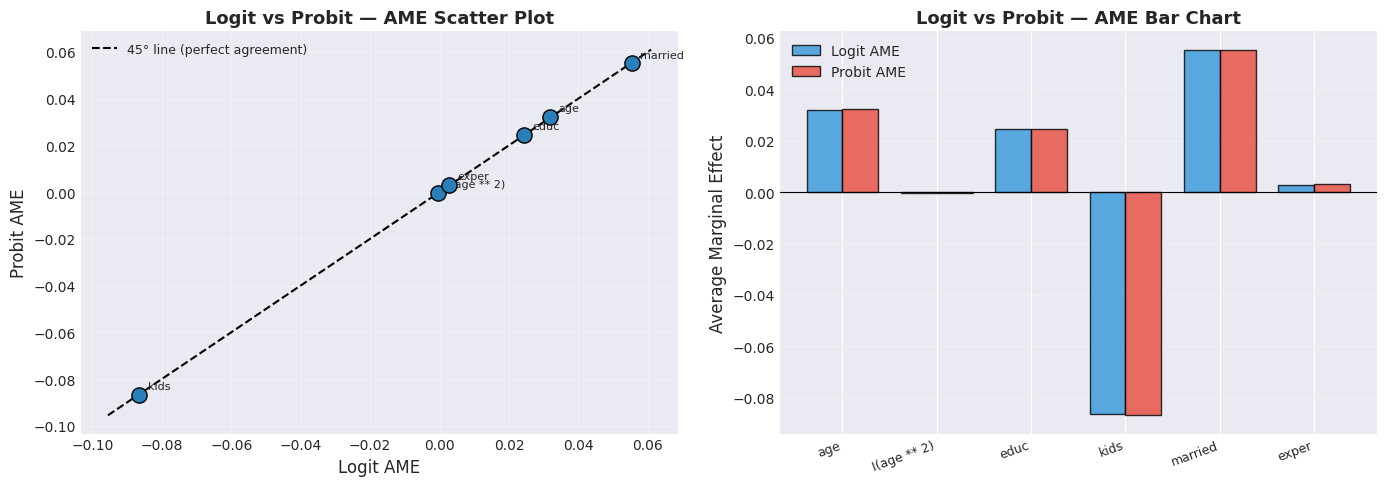


=== Summary Statistics ===
Mean Absolute Difference (MAD): 0.000198
Correlation:                    0.999991

=== Conclusion ===
The AMEs from Logit and Probit are nearly identical (MAD = 0.0002,
correlation = 1.0000). The two models agree on:
  - Sign (direction) of all effects
  - Statistical significance
  - Approximate magnitude

Practical rule: Logit and Probit are interchangeable for most applications.
Choose based on convention in your field, not expected AME differences.


In [34]:
# Exercise 3: Logit vs Probit AME Comparison

formula_ex3 = 'lfp ~ age + I(age**2) + educ + kids + married + exper'

# Step 1: Estimate models
logit_ex3_model  = PooledLogit(formula_ex3, data, 'id', 'year')
probit_ex3_model = PooledProbit(formula_ex3, data, 'id', 'year')

logit_ex3_res  = logit_ex3_model.fit(cov_type='cluster')
probit_ex3_res = probit_ex3_model.fit(cov_type='cluster')

print('=== Models estimated ===')
print(f'Logit  — log-likelihood: {logit_ex3_res.llf:.4f}')
print(f'Probit — log-likelihood: {probit_ex3_res.llf:.4f}')

# Step 2: Compute AME
ame_logit_ex3  = compute_ame(logit_ex3_res)
ame_probit_ex3 = compute_ame(probit_ex3_res)

# Common variables (excluding constant)
common_vars_ex3 = [v for v in ame_logit_ex3.marginal_effects.index
                   if v in ame_probit_ex3.marginal_effects.index
                   and 'Intercept' not in v and 'const' not in v]

ame_logit_vals  = [ame_logit_ex3.marginal_effects[v] for v in common_vars_ex3]
ame_probit_vals = [ame_probit_ex3.marginal_effects[v] for v in common_vars_ex3]

print('\n=== AME Comparison: Logit vs Probit ===')
print(f'{"Variable":20s}  {"Logit AME":>12}  {"Probit AME":>12}  {"Abs Diff":>12}')
print('-' * 62)
for v, lv, pv in zip(common_vars_ex3, ame_logit_vals, ame_probit_vals):
    print(f'{v:20s}  {lv:>12.6f}  {pv:>12.6f}  {abs(lv-pv):>12.6f}')

# Step 3: Scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: scatter Logit vs Probit AME
axes[0].scatter(ame_logit_vals, ame_probit_vals, s=120, color='#2980b9',
                edgecolors='black', zorder=5)
# 45-degree line
lims = [min(ame_logit_vals + ame_probit_vals) * 1.1,
        max(ame_logit_vals + ame_probit_vals) * 1.1]
axes[0].plot(lims, lims, 'k--', linewidth=1.5, label='45° line (perfect agreement)')

for v, lv, pv in zip(common_vars_ex3, ame_logit_vals, ame_probit_vals):
    axes[0].annotate(v, (lv, pv), textcoords='offset points', xytext=(6, 4), fontsize=8)

axes[0].set_xlabel('Logit AME', fontsize=12)
axes[0].set_ylabel('Probit AME', fontsize=12)
axes[0].set_title('Logit vs Probit — AME Scatter Plot', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Right: bar chart comparison
x_pos_ex3 = np.arange(len(common_vars_ex3))
width_ex3  = 0.38
axes[1].bar(x_pos_ex3 - width_ex3/2, ame_logit_vals,  width_ex3, label='Logit AME',
            color='#3498db', edgecolor='black', alpha=0.8)
axes[1].bar(x_pos_ex3 + width_ex3/2, ame_probit_vals, width_ex3, label='Probit AME',
            color='#e74c3c', edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos_ex3)
axes[1].set_xticklabels(common_vars_ex3, rotation=20, ha='right', fontsize=9)
axes[1].set_ylabel('Average Marginal Effect', fontsize=12)
axes[1].set_title('Logit vs Probit — AME Bar Chart', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].axhline(y=0, color='black', linewidth=0.8)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'ex3_logit_vs_probit_ame.png', dpi=150, bbox_inches='tight')
plt.show()

# Step 4: Mean absolute difference
ame_l_arr  = np.array(ame_logit_vals)
ame_p_arr  = np.array(ame_probit_vals)
MAD        = np.mean(np.abs(ame_l_arr - ame_p_arr))
corr       = np.corrcoef(ame_l_arr, ame_p_arr)[0, 1]

print(f'\n=== Summary Statistics ===')
print(f'Mean Absolute Difference (MAD): {MAD:.6f}')
print(f'Correlation:                    {corr:.6f}')

# Step 5: Conclusion
print('\n=== Conclusion ===')
print(f'The AMEs from Logit and Probit are nearly identical (MAD = {MAD:.4f},')
print(f'correlation = {corr:.4f}). The two models agree on:')
print('  - Sign (direction) of all effects')
print('  - Statistical significance')
print('  - Approximate magnitude')
print()
print('Practical rule: Logit and Probit are interchangeable for most applications.')
print('Choose based on convention in your field, not expected AME differences.')

---

### Exercise 4: Comprehensive Visualization (Hard)

Create a **2×2 figure** showing:

1. (top-left) MEM vs AME vs MER bar chart for all variables
2. (top-right) Distribution of individual MEs for `educ`
3. (bottom-left) ME of `educ` as a function of `age`
4. (bottom-right) Forest plot with AME ± 95% CI for all variables

**Bonus**: Add vertical dashed lines for the sample mean and median in the top-right panel.

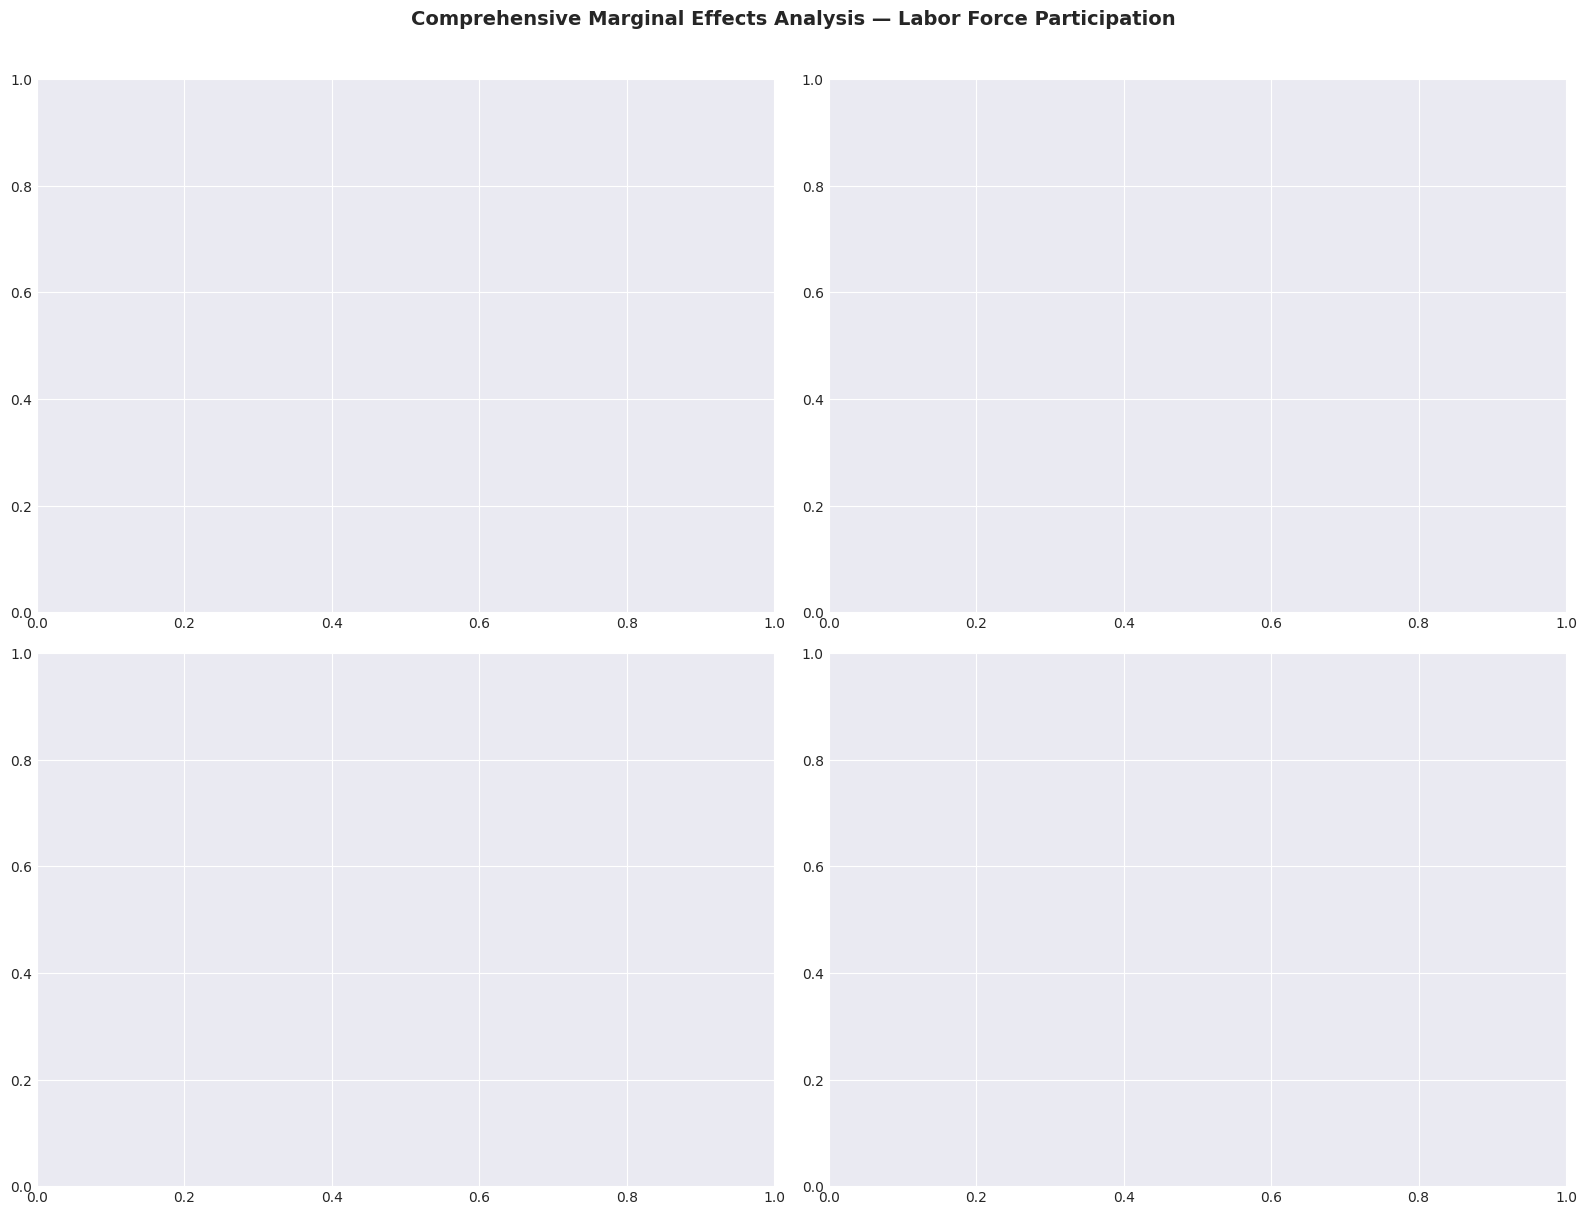

In [35]:
# Exercise 4: Your solution here

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel (0,0): MEM vs AME vs MER bar chart
# TODO: axes[0, 0].bar(...)

# Panel (0,1): Distribution of individual MEs for educ
# TODO: axes[0, 1].hist(...)

# Panel (1,0): ME of educ as function of age
# TODO: axes[1, 0].plot(...)

# Panel (1,1): Forest plot
# TODO: axes[1, 1].errorbar(...)

plt.suptitle('Comprehensive Marginal Effects Analysis — Labor Force Participation',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---

## Summary and Key Takeaways

### What We Learned

| Concept | Key Point |
|---------|----------|
| **β ≠ ME** | In nonlinear models, $\partial P/\partial x_k = f(\mathbf{X}'\boldsymbol{\beta}) \cdot \beta_k$ — varies with X |
| **MEM** | Evaluate $f$ at sample mean: simple but fragile |
| **AME** ⭐ | Average across all observations: **best practice** |
| **MER** | Evaluate at chosen X*: useful for policy scenarios |
| **Dummy ME** | Use discrete difference, not derivative |
| **Delta Method** | Correct way to get SEs for nonlinear functions of β |
| **FE Logit ME** | Tricky — individual effects not estimated |
| **Reporting** | Report AME in percentage points with SEs and CIs |

### Common Pitfalls to Avoid

1. **Reporting β as a probability effect** — it is not
2. **Using derivative formula for dummies** — use discrete difference
3. **Not reporting standard errors** for marginal effects
4. **Using MEM with binary covariates** — average of a dummy ≠ meaningful value
5. **Ignoring heterogeneity** — the single AME number hides variation

### PanelBox Quick Reference

```python
from panelbox.marginal_effects import compute_ame, compute_mem, compute_mer

# Fit model
results = PooledLogit(formula, data, 'id', 'year').fit(cov_type='cluster')

# Compute marginal effects
ame = compute_ame(results)                          # all variables
ame = compute_ame(results, varlist=['educ', 'age']) # specific variables
mem = compute_mem(results)
mer = compute_mer(results, at={'age': 35, 'educ': 12})

# Access results
ame.marginal_effects  # pd.Series of AME values
ame.std_errors        # pd.Series of delta-method SEs
ame.pvalues           # pd.Series of p-values
ame.conf_int()        # pd.DataFrame with 'lower' and 'upper'
ame.summary()         # formatted table (also prints to screen)
```

---

## References

1. **Bartus, T. (2005)**. "Estimation of marginal effects using margeff." *Stata Journal*, 5(3), 309–329.

2. **Cameron, A. C., & Trivedi, P. K. (2010)**. *Microeconometrics Using Stata* (Revised ed.). Stata Press. Chapter 14.

3. **Greene, W. H. (2018)**. *Econometric Analysis* (8th ed.). Pearson. Chapter 17.

4. **Wooldridge, J. M. (2010)**. *Econometric Analysis of Cross Section and Panel Data* (2nd ed.). MIT Press. Chapter 15.

5. **Chamberlain, G. (1980)**. "Analysis of covariance with qualitative data." *Review of Economic Studies*, 47(1), 225–238.

---

**Notebook 05** → Multinomial and Ordered Choice Models